In [1]:
# Importing the libraries
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder('/kaggle/input/new-30/mammals', transform=transform)
print(len(full_dataset))

4500


In [3]:
train_size = int(0.8 * len(full_dataset))

validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [5]:
googlenet = models.googlenet(pretrained=False)

googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, 30)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.005, momentum=0.9)

In [16]:
# Set the number of epochs
epochs = 10

for epoch in range(epochs):
    googlenet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation loop
    googlenet.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {validation_loss/len(validation_loader)}, Accuracy: {100 * correct / total}%')

Epoch 1/10, Loss: 0.014769544353115215
Validation Loss: 1.8297454735328411, Accuracy: 64.11111111111111%
Epoch 2/10, Loss: 0.005813737890777895
Validation Loss: 1.8480462431907654, Accuracy: 64.22222222222223%
Epoch 3/10, Loss: 0.005302967615832525
Validation Loss: 1.8121962423982292, Accuracy: 64.22222222222223%
Epoch 4/10, Loss: 0.004816965291181793
Validation Loss: 1.8038072791592827, Accuracy: 64.33333333333333%
Epoch 5/10, Loss: 0.003666813261636978
Validation Loss: 1.7795295776992008, Accuracy: 63.666666666666664%
Epoch 6/10, Loss: 0.0032735147709964437
Validation Loss: 1.7436840986383373, Accuracy: 65.66666666666667%
Epoch 7/10, Loss: 0.0030733761584965215
Validation Loss: 1.7836499152512386, Accuracy: 63.55555555555556%
Epoch 8/10, Loss: 0.0034006974346672014
Validation Loss: 1.7971498308510616, Accuracy: 65.44444444444444%
Epoch 9/10, Loss: 0.0026730289354362008
Validation Loss: 1.7391741358000656, Accuracy: 64.33333333333333%
Epoch 10/10, Loss: 0.003102037515305807
Validation

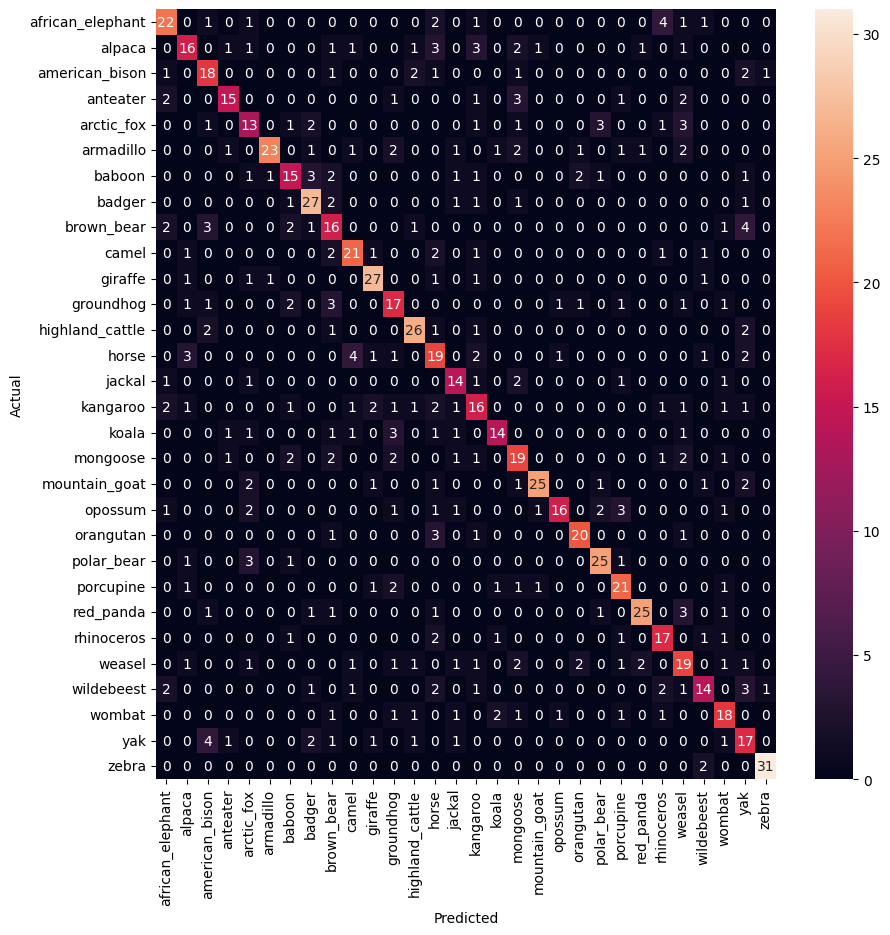

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=validation_dataset.dataset.classes,
            yticklabels=validation_dataset.dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
from sklearn.metrics import classification_report

all_preds = np.array(predlist)
all_labels = np.array(lbllist)

class_report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)
print(class_report)

                  precision    recall  f1-score   support

african_elephant       0.67      0.67      0.67        33
          alpaca       0.62      0.50      0.55        32
  american_bison       0.58      0.67      0.62        27
        anteater       0.75      0.60      0.67        25
      arctic_fox       0.48      0.50      0.49        26
       armadillo       0.92      0.62      0.74        37
          baboon       0.58      0.54      0.56        28
          badger       0.71      0.79      0.75        34
      brown_bear       0.46      0.53      0.49        30
           camel       0.68      0.70      0.69        30
         giraffe       0.79      0.82      0.81        33
       groundhog       0.53      0.59      0.56        29
 highland_cattle       0.76      0.79      0.78        33
           horse       0.45      0.56      0.50        34
          jackal       0.58      0.67      0.62        21
        kangaroo       0.47      0.50      0.48        32
           ko